In [1]:
# !pip install ray

Defaulting to user installation because normal site-packages is not writeable
     ---------------------------------------- 24.2/24.2 MB 8.4 MB/s eta 0:00:00
     -------------------------------------- 413.4/413.4 kB 8.8 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.19.5
    Uninstalling protobuf-3.19.5:
      Successfully uninstalled protobuf-3.19.5


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
web3 5.31.3 requires protobuf==3.19.5, but you have protobuf 4.25.1 which is incompatible.


In [98]:
import warnings
warnings.filterwarnings("ignore")
dataset = "mushrooms.txt"

In [99]:
from sklearn.datasets import load_svmlight_file
data = load_svmlight_file(dataset)
X, y = data[0].toarray(), data[1]

In [100]:
y = 2 * y - 3

In [101]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [102]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(6499, 112) (6499,)
(1625, 112) (1625,)


In [46]:
# import numpy as np

# def logistic_loss(x, a, y, lambd):
#     logistic_loss = np.log(1 + np.exp(-y * (a @ x))).mean()
#     nonconvex_reg = lambd * np.sum(x ** 2 / (1 + x ** 2))
#     return logistic_loss + nonconvex_reg

# def logistic_gradient(x, a, y, lambd):
#     logistic_grad = (-y / (1 + np.exp(y * np.dot(a, x)))) * a
#     nonconvex_reg_grad = 2 * lambd * x / (1 + x ** 2) ** 2
#     return logistic_grad.mean(axis=0) + nonconvex_reg_grad

In [103]:
def logistic_loss(w, X, y, lambda_reg):
    z = np.dot(X, w)
    loss = np.mean(np.log(1 + np.exp(-y * z))) + lambda_reg * np.sum(w ** 2 / (1 + w ** 2))
    return loss

def logistic_gradient(w, X, y, lambda_reg):
    z = np.dot(X, w)
    grad = (-y / (1 + np.exp(y * z)))
    gradient = np.dot(X.T, grad) / y.shape[0] + 2 * lambda_reg * w / (1 + w ** 2) ** 2
    return gradient

# def logistic_hessian(w, X, y, lambda_reg):
#     z = np.dot(X, w)
#     s = np.exp(y * z) / (1 + np.exp(y * z))**2
#     S = np.diag(s)
#     hessian = np.dot(np.dot(X.T, S), X) / len(y) + lambda_reg * np.eye(X.shape[1])
#     return hessian

Function for estimate L using the given training data

In [104]:
def estimate_L(X_train):
    n = X_train.shape[0]
    norms = np.linalg.norm(X_train, axis=1)**2
    L = np.max(norms) / (4.0 * n)
    return L

def calculate_logistic_regression(X, y, lambda_reg):
    w_initial = np.zeros(X.shape[1])
    value = logistic_loss(w_initial, X, y, lambda_reg)
    gradient = logistic_gradient(w_initial, X, y, lambda_reg)
#     hessian = logistic_hessian(w_initial, X, y, lambda_reg)
    return value, gradient

In [105]:
L = estimate_L(X_train)
lambda_reg = L / 1000


value, gradient = calculate_logistic_regression(X_train, y_train, lambda_reg)

print("Objective function value:", value)
print("Gradient at the initial point:", gradient)
# print("Hessian at the initial point:", hessian)

Objective function value: 0.6931471805599453
Gradient at the initial point: [ 0.0002308  -0.02100323 -0.00184644  0.02338821 -0.00207724 -0.01646407
  0.01430989  0.01707955  0.0002308  -0.04939221 -0.00123096  0.00423142
  0.01538698 -0.0145407  -0.01315587  0.0015387  -0.00092322 -0.00107709
 -0.02538852  0.01738729 -0.13178951  0.11401754 -0.02461917  0.01192491
  0.1330974   0.00238498 -0.02361902 -0.20333898  0.01531005  0.03623634
  0.03485152 -0.01046315 -0.00730882  0.04854593 -0.0663179  -0.13894445
  0.12117249  0.10755501 -0.00630866  0.01515618  0.01884905 -0.01623327
 -0.00376981 -0.05131559 -0.0114633   0.00138483 -0.02431143 -0.04516079
 -0.00215418  0.01684875 -0.03462071 -0.00046161 -0.13025081  0.12994307
 -0.01700262 -0.00738575 -0.11632559  0.1251731  -0.01923373  0.00238498
  0.02661948 -0.00630866 -0.03562086 -0.01169411  0.02561933  0.04416064
 -0.0634713   0.00053854  0.00238498  0.02669641 -0.0063856  -0.03554393
 -0.01169411  0.02300354  0.04600708 -0.06354824

In [106]:
def create_batches(X, y, b):
    n_batches = len(X) // b
    batches = []

    for i in range(n_batches):
        batch_x = X[i*b:(i+1)*b]
        batch_y = y[i*b:(i+1)*b]
        batches.append((batch_x, batch_y))

    return batches

b = 10
batches = create_batches(X_train, y_train, b)

print(len(X_train))
print(len(batches))

6499
649


In [107]:
def create_heterogeneous_batches(X, y, b, heterogeneity_factor=0.5):

    n_batches = len(X) // b
    positive_indices = np.where(y == 1)[0]
    negative_indices = np.where(y == -1)[0]

    np.random.shuffle(positive_indices)
    np.random.shuffle(negative_indices)

    batches = []
    for i in range(n_batches):
        pos_count = int(b * heterogeneity_factor)
        neg_count = b - pos_count

        selected_pos = positive_indices[:pos_count]
        selected_neg = negative_indices[:neg_count]

        positive_indices = positive_indices[pos_count:]
        negative_indices = negative_indices[neg_count:]

        batch_indices = np.concatenate([selected_pos, selected_neg])
        np.random.shuffle(batch_indices)
        batch_x = X[batch_indices]
        batch_y = y[batch_indices]

        batches.append((batch_x, batch_y))

    return batches

In [108]:
b = 10
heterogeneity_factor = 0.8
batches = create_heterogeneous_batches(X_train, y_train, b, heterogeneity_factor)
print(len(batches))

649


In [109]:
import ray

ray.init(ignore_reinit_error=True)

@ray.remote
def logistic_loss_gradient_hessian(X, y, lambda_reg):
    w = np.zeros(X.shape[1])
    value = logistic_loss(w, X, y, lambda_reg)
    gradient = logistic_gradient(w, X, y, lambda_reg)
#     hessian = logistic_hessian(w, X, y, lambda_reg)
    return value, gradient

futures = [logistic_loss_gradient_hessian.remote(batch_x, batch_y, lambda_reg) for (batch_x, batch_y) in batches]
results = ray.get(futures)

2023-12-21 11:58:26,017	INFO worker.py:1507 -- Calling ray.init() again after it has already been called.


In [84]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from tqdm.autonotebook import tqdm
import warnings
warnings.filterwarnings('ignore')

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

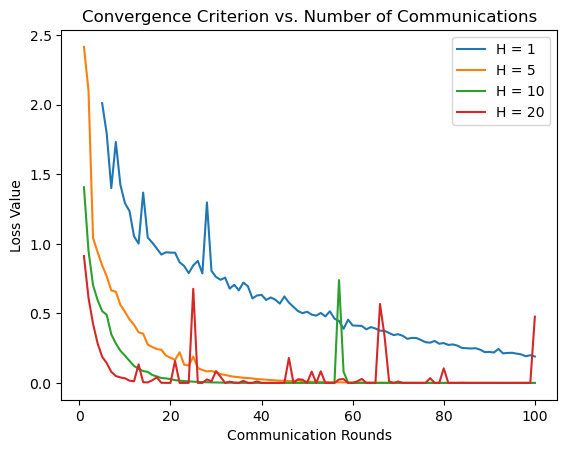

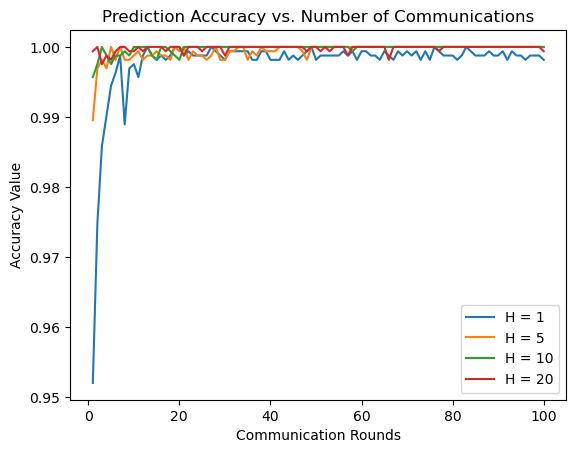

In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from tqdm.autonotebook import tqdm
import warnings
warnings.filterwarnings('ignore')

local_steps = [1, 5, 10, 20]
loss_results = {H: [] for H in local_steps}
accuracy_results = {H: [] for H in local_steps}
communication_rounds = {H: [] for H in local_steps}

def compute_accuracy(w, X, y_true):
    y_pred = np.sign(np.dot(X, w))
    return accuracy_score(y_true, y_pred)

In [110]:
def randk_compression(vector, k):
    """
    Randomly select k coordinates to keep and set others to zero.
    """
    compressed = np.zeros_like(vector)
    indices = np.random.choice(range(len(vector)), k, replace=False)
    compressed[indices] = vector[indices]
    return compressed

def topk_compression(vector, k):
    """
    Keep top k coordinates by absolute value and set others to zero.
    """
    compressed = np.zeros_like(vector)
    indices = np.abs(vector).argsort()[-k:]
    compressed[indices] = vector[indices]
    return compressed

In [86]:
def distributed_gd_compression_1(X, y, s, L, omega, compression_func, num_rounds, lambda_reg, heterogeneity_factor):
    n, d = X.shape
    w_global = np.zeros(d)

    step_size = L**(-1) * (2 * omega / s + 1)**(-1)
    batches = create_heterogeneous_batches(X, y, n // s, heterogeneity_factor)

    for round in range(num_rounds):
        gradients = []

        for idx, (batch_x, batch_y) in enumerate(batches):
            w_local = np.copy(w_global)
            gradient = logistic_gradient(w_local, batch_x, batch_y, lambda_reg)
            gradients.append(compression_func(gradient, k=int(d * omega)))

        w_global -= step_size * np.mean(gradients, axis=0)

    return w_global

In [23]:
s=10
omega=0.2
step_size = L**(-1) * (2 * omega / s + 1)**(-1)

# heterogeneity_factors = [0.1, 0.3, 0.5, 0.7, 0.9]
# loss_results_cr1 = {hf: [] for hf in heterogeneity_factors}
# accuracy_results_cr1 = {hf: [] for hf in heterogeneity_factors}
# communication_rounds_cr1 = {hf: [] for hf in heterogeneity_factors}

# for heterogeneity_factor in tqdm(heterogeneity_factors):
#     w_fedavg = np.zeros(X_train.shape[1])
#     for round in tqdm(range(1, 101)):
#         w_compressed = distributed_gd_compression_1(X_train_fold, y_train_fold, s, step_size,
#                                                       rate, randk_compression, num_rounds, lambda_reg, heterogeneity_factor=heterogeneity_factor)
#         loss = logistic_loss(w_compressed, X_test, y_test, lambda_reg)
#         accuracy = compute_accuracy(w_compressed, X_test, y_test)

#         communication_rounds_cr1[heterogeneity_factor].append(round)
#         loss_results_cr1[heterogeneity_factor].append(loss)
#         accuracy_results_cr1[heterogeneity_factor].append(accuracy)

__e). (15 points)__ Now we use $s=10$, uniformly distributed data and $\text{Top}10\%$ as compression operators. Compress the information only from the devices to the server. Use two methods: simple distributed gradient descent with compression operators, and distributed gradient descent with error feedback technique (see Algorithm 1 from [article](https://arxiv.org/abs/2002.12410)). For each method, select the step for the "best" convergence. Draw the comparison plots for two approaches without and with error feedback with "best" steps: 1) convergence criterion value versus number of transmitted coordinates from the devices to the server, 2) prediction accuracy versus number of transmitted coordinates from the devices to the server. Make a conclusion.

In [111]:
y_train

array([-1., -1., -1., ...,  1., -1.,  1.])

In [122]:
def distributed_gd_with_feedback(X, y, s, compression_func, num_rounds, lambda_reg, step_size, heterogeneity_factor):
    n, d = X.shape
    w = np.zeros(d)
    error_accumulator = np.zeros((s, d))
    losses = []
    accuracies = []

    batches = create_heterogeneous_batches(X, y, n // s, heterogeneity_factor)

    for round in range(num_rounds):
        gradients = []
        corrections = []

        for idx, (batch_x, batch_y) in enumerate(batches):
            gradient = logistic_gradient(w - step_size * error_accumulator[idx], batch_x, batch_y, lambda_reg)
            compressed_gradient = compression_func(gradient, k=1)
            corrections.append(gradient - compressed_gradient)
            gradients.append(compressed_gradient)

        w -= step_size * np.mean(gradients, axis=0)
        error_accumulator += corrections
        losses.append(logistic_loss(w, X, y, lambda_reg))
        accuracies.append(compute_accuracy(w, X, y))

    return w, losses, accuracies

In [123]:
def EF21(X, y, s, num_rounds, gamma, lambda_reg, compression_func, heterogeneity_factor):
    n, d = X.shape
    x = np.zeros(d)
    
    batches = create_heterogeneous_batches(X, y, n // s, heterogeneity_factor)
    g = np.array([compression_func(logistic_gradient(x, batch_x, batch_y, lambda_reg), k=1)
                  for batch_x, batch_y in batches])

    global_g = np.mean(g, axis=0)
    
    for t in range(num_rounds):
        x -= gamma * global_g
        c = np.zeros_like(g)
        for i, (batch_x, batch_y) in enumerate(batches):
            full_gradient = logistic_gradient(x, batch_x, batch_y, lambda_reg)
            c[i] = compression_func(full_gradient - g[i], k=1)
            g[i] += c[i]
        global_g += np.mean(c, axis=0)
        
    losses = logistic_loss(x, np.vstack([b[0] for b in batches]), np.concatenate([b[1] for b in batches]), lambda_reg)
    accuracies = compute_accuracy(x, np.vstack([b[0] for b in batches]), np.concatenate([b[1] for b in batches]))
    
    return x, losses, accuracies

In [124]:
from sklearn.metrics import accuracy_score
from tqdm.autonotebook import tqdm
def compute_accuracy(w, X, y_true):
    y_pred = np.sign(np.dot(X, w))
    return accuracy_score(y_true, y_pred)

In [126]:
s=10
omega=0.2
step_size = L**(-1) * (2 * omega / s + 1)**(-1)

loss_gdc = []
accuracy_gdc = []
com_ro = []

loss_wf = []
accuracy_wf = []

for round_ in tqdm(range(1, 101)):
#     w_compressed = distributed_gd_compression_1(X_train_fold, y_train_fold, s, step_size, rate, randk_compression, round, lambda_reg, heterogeneity_factor=heterogeneity_factor)
    w_dgd, losses_dgd, accuracies_dgd = distributed_gd_with_feedback(X_train, y_train, s=10, compression_func=topk_compression, num_rounds=round_, lambda_reg=lambda_reg, step_size=step_size, heterogeneity_factor=heterogeneity_factor)
#     loss = logistic_loss(w_compressed, X_test, y_test, lambda_reg)
#     accuracy = compute_accuracy(w_compressed, X_test, y_test)
    w_ef21, losses_ef21, accuracies_ef21 = EF21(
        X_train,
        y_train,
        s=10,
        num_rounds=round_,
        gamma=step_size,
        lambda_reg=lambda_reg,
        compression_func=topk_compression,
        heterogeneity_factor=heterogeneity_factor
    )
    loss_1 = logistic_loss(w_dgd, X_test, y_test, lambda_reg)
    accuracy_1 = compute_accuracy(w_dgd, X_test, y_test)
    
    loss = logistic_loss(w_ef21, X_test, y_test, lambda_reg)
    accuracy = compute_accuracy(w_ef21, X_test, y_test)
    
    com_ro.append(round_)
    loss_gdc.append(loss)
    accuracy_gdc.append(accuracy)
    loss_wf.append(loss_1)
    accuracy_wf.append(accuracy_1)

  0%|          | 0/100 [00:00<?, ?it/s]

In [127]:
losses_ef21

inf

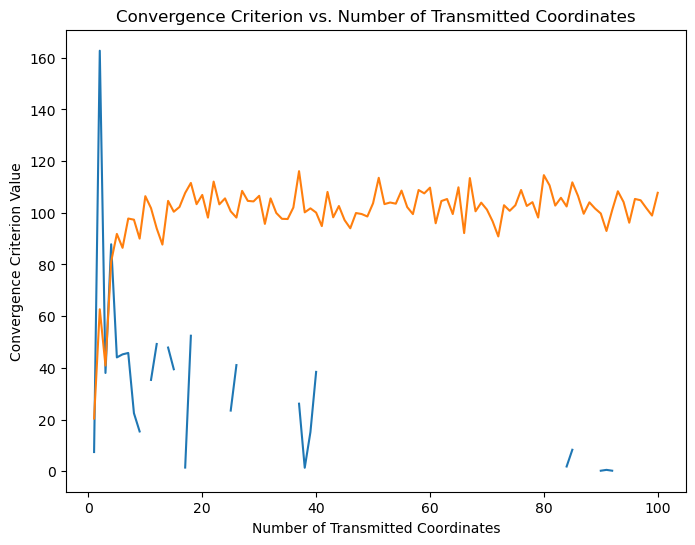

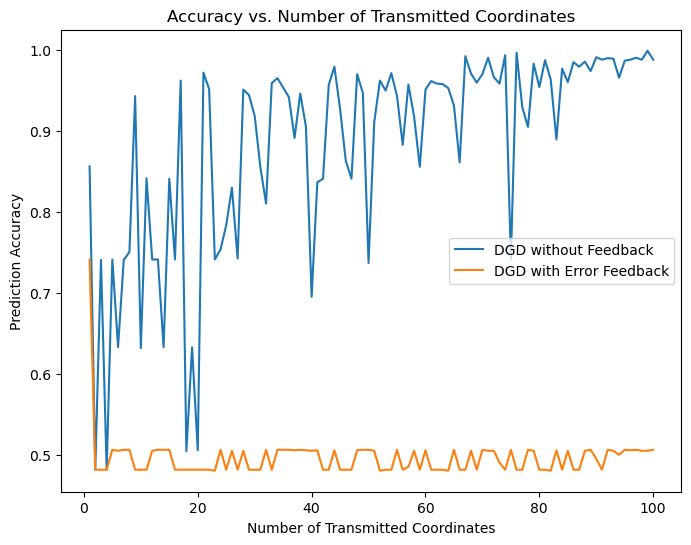

In [129]:
import matplotlib.pyplot as plt
d=1
plt.figure(figsize=(8, 6))
plt.plot(np.cumsum([d  for _ in range(100)]), loss_gdc, label="DGD without Feedback")
plt.plot(np.cumsum([d for _ in range(100)]), loss_wf, label="DGD with Error Feedback")
plt.xlabel('Number of Transmitted Coordinates')
plt.ylabel('Convergence Criterion Value')
plt.title('Convergence Criterion vs. Number of Transmitted Coordinates')

plt.figure(figsize=(8, 6))
plt.plot(np.cumsum([d for _ in range(100)]),accuracy_gdc, label="DGD without Feedback")
plt.plot(np.cumsum([d for _ in range(100)]),accuracy_wf, label="DGD with Error Feedback")
plt.xlabel('Number of Transmitted Coordinates')
plt.ylabel('Prediction Accuracy')
plt.title('Accuracy vs. Number of Transmitted Coordinates')
plt.legend()
plt.show()

In [130]:
s=10
omega=0.2
step_size = L**(-1) * (2 * omega / s + 1)**(-1)

loss_gdc = []
accuracy_gdc = []
com_ro = []

loss_wf = []
accuracy_wf = []

for round_ in tqdm(range(1, 1001)):
#     w_compressed = distributed_gd_compression_1(X_train_fold, y_train_fold, s, step_size, rate, randk_compression, round, lambda_reg, heterogeneity_factor=heterogeneity_factor)
    w_dgd, losses_dgd, accuracies_dgd = distributed_gd_with_feedback(X_train, y_train, s=10, compression_func=topk_compression, num_rounds=round_, lambda_reg=lambda_reg, step_size=step_size, heterogeneity_factor=heterogeneity_factor)
#     loss = logistic_loss(w_compressed, X_test, y_test, lambda_reg)
#     accuracy = compute_accuracy(w_compressed, X_test, y_test)
    w_ef21, losses_ef21, accuracies_ef21 = EF21(
        X_train,
        y_train,
        s=10,
        num_rounds=round_,
        gamma=step_size,
        lambda_reg=lambda_reg,
        compression_func=topk_compression,
        heterogeneity_factor=heterogeneity_factor
    )
    loss_1 = logistic_loss(w_dgd, X_test, y_test, lambda_reg)
    accuracy_1 = compute_accuracy(w_dgd, X_test, y_test)
    
    loss = logistic_loss(w_ef21, X_test, y_test, lambda_reg)
    accuracy = compute_accuracy(w_ef21, X_test, y_test)
    
    com_ro.append(round_)
    loss_gdc.append(loss)
    accuracy_gdc.append(accuracy)
    loss_wf.append(loss_1)
    accuracy_wf.append(accuracy_1)

  0%|          | 0/1000 [00:00<?, ?it/s]

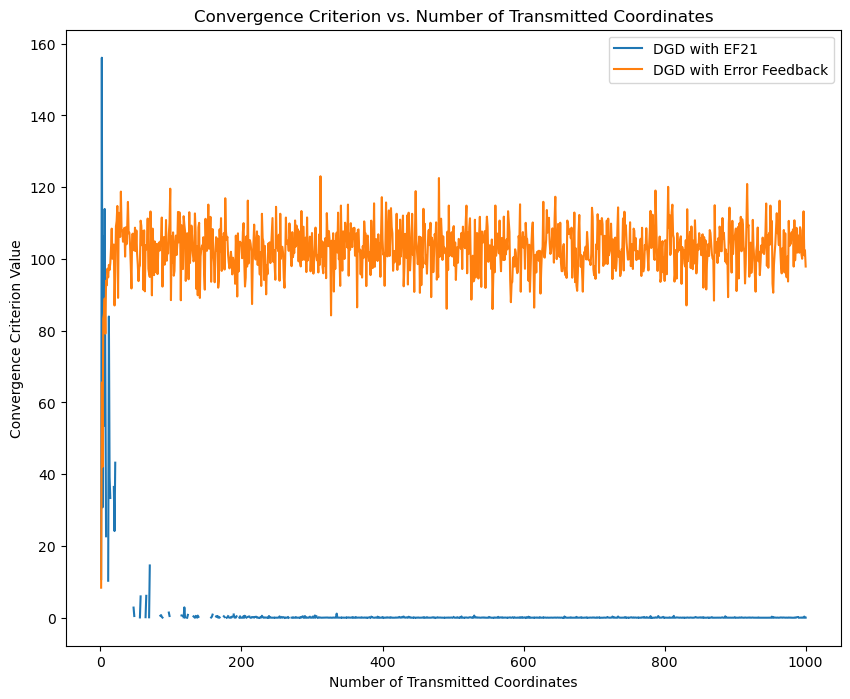

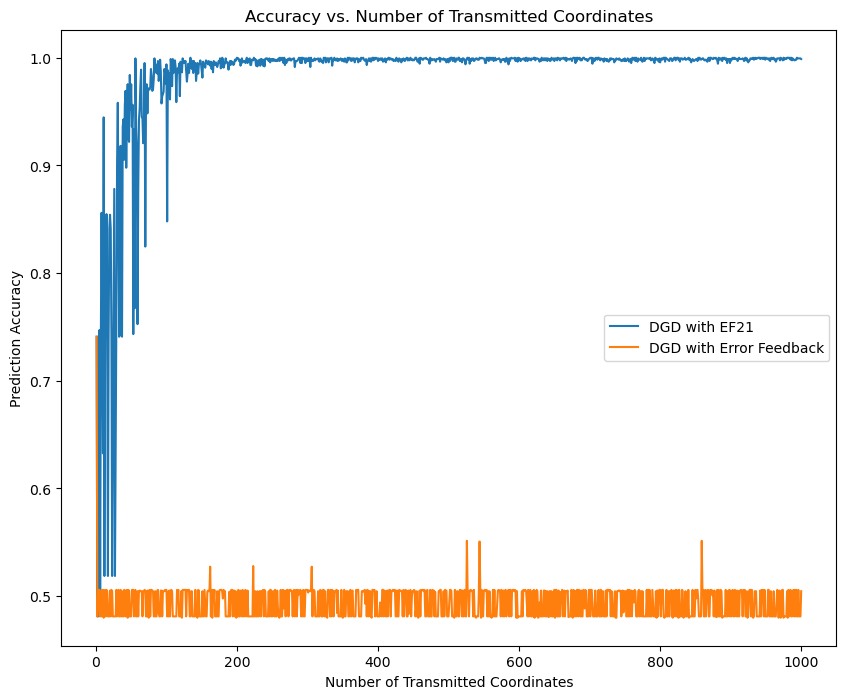

In [135]:
import matplotlib.pyplot as plt
d=1
plt.figure(figsize=(10, 8))
plt.plot(np.cumsum([d  for _ in range(1000)]), loss_gdc, label="DGD with EF21")
plt.plot(np.cumsum([d for _ in range(1000)]), loss_wf, label="DGD with Error Feedback")
plt.xlabel('Number of Transmitted Coordinates')
plt.ylabel('Convergence Criterion Value')
plt.title('Convergence Criterion vs. Number of Transmitted Coordinates')
plt.legend()

plt.figure(figsize=(10, 8))
plt.plot(np.cumsum([d for _ in range(1000)]),accuracy_gdc, label="DGD with EF21")
plt.plot(np.cumsum([d for _ in range(1000)]),accuracy_wf, label="DGD with Error Feedback")
plt.xlabel('Number of Transmitted Coordinates')
plt.ylabel('Prediction Accuracy')
plt.title('Accuracy vs. Number of Transmitted Coordinates')
plt.legend()
plt.show()

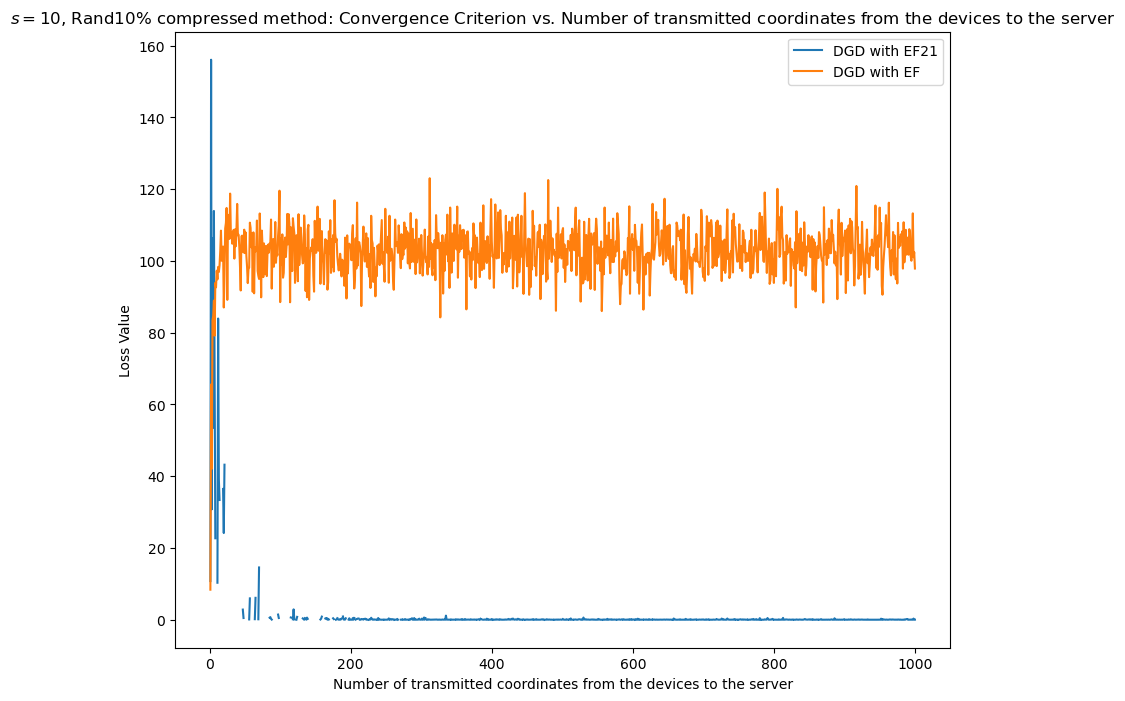

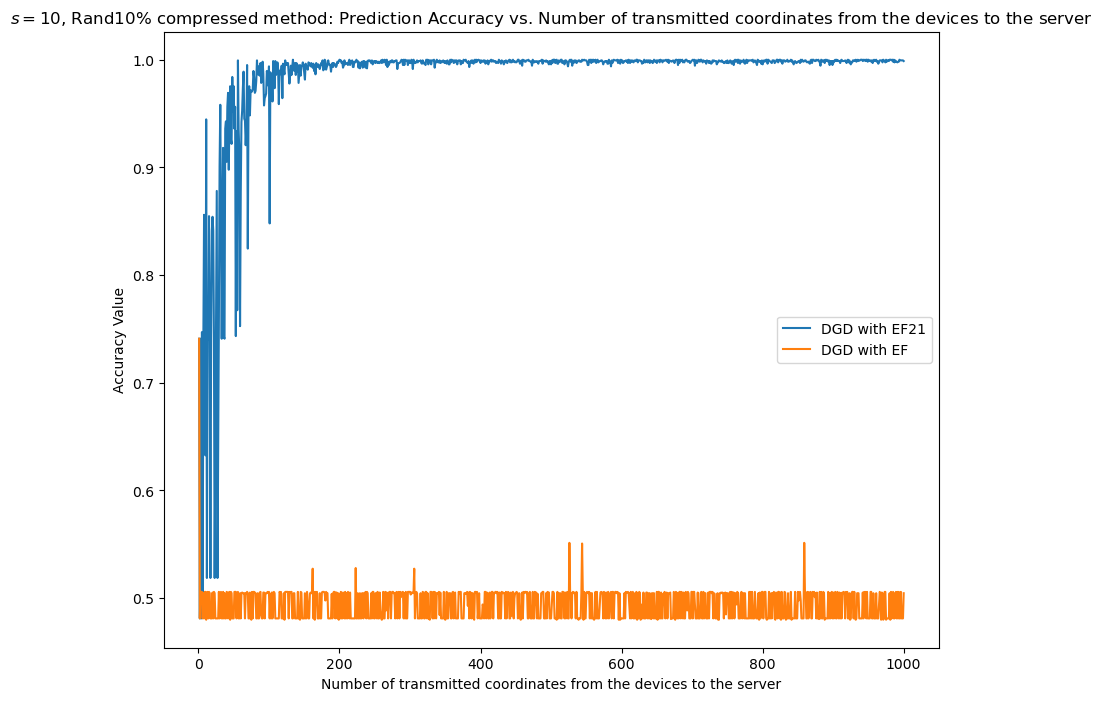

In [140]:
plt.figure(figsize=(10, 8))
plt.plot(com_ro, loss_gdc, label="DGD with EF21")
plt.plot(com_ro, loss_wf, label="DGD with EF")
plt.xlabel('Number of transmitted coordinates from the devices to the server')
plt.ylabel('Loss Value')
plt.title('$s = 10$, Rand10% compressed method: Convergence Criterion vs. Number of transmitted coordinates from the devices to the server')
plt.legend()
plt.show()

plt.figure(figsize=(10, 8))
plt.plot(com_ro, accuracy_gdc, label="DGD with EF21")
plt.plot(com_ro, accuracy_wf, label="DGD with EF")

plt.xlabel('Number of transmitted coordinates from the devices to the server')
plt.ylabel('Accuracy Value')
plt.title('$s = 10$, Rand10% compressed method: Prediction Accuracy vs. Number of transmitted coordinates from the devices to the server')
plt.legend()
plt.show()